In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=20,20
import seaborn as sns
from fastaUtils.profiles import parse_profile,profile_data
from sklearn.decomposition import PCA
from umap import UMAP

tfk=tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

## Classes and helper functions

In [2]:
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
class LRFinder(Callback):
    def __init__(self, min_lr, max_lr, mom=0.9, stop_multiplier=None, 
                 reload_weights=True, batches_lr_update=5):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20*self.mom/3 + 10 # 4 if mom=0.9
                                                       # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier
        
    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p['epochs']*p['samples']//p['batch_size']
        except:
            n_iterations = p['steps']*p['epochs']
            
        self.learning_rates = np.geomspace(self.min_lr, self.max_lr, \
                                           num=n_iterations//self.batches_lr_update+1)
        self.losses=[]
        self.iteration=0
        self.best_loss=0
        if self.reload_weights:
            self.model.save_weights('tmp.hdf5')
        
    
    def on_batch_end(self, batch, logs={}):
        loss = logs.get('loss')
        
        if self.iteration!=0: # Make loss smoother using momentum
            loss = self.losses[-1]*self.mom+loss*(1-self.mom)
        
        if self.iteration==0 or loss < self.best_loss: 
                self.best_loss = loss
                
        if self.iteration%self.batches_lr_update==0: # Evaluate each lr over 5 epochs
            
            if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
          
            lr = self.learning_rates[self.iteration//self.batches_lr_update]            
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)            

        if loss > self.best_loss*self.stop_multiplier: # Stop criteria
            self.model.stop_training = True
                
        self.iteration += 1
    
    def on_train_end(self, logs=None):
        if self.reload_weights:
                self.model.load_weights('tmp.hdf5')
                
        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[:len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale('log')
        plt.show()

In [3]:
class AutoregressiveGenerate(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveGenerate, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.concat = tfkl.concatenate
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = tfd.OneHotCategorical(logits=x,dtype=tf.float32).sample()
    x = self.concat([input_tensor,x])
    return x

class AutoregressiveFit(tf.keras.Model):
  def __init__(self, model, name=''):
    super(AutoregressiveFit, self).__init__(name=name)
    self.model=tfk.models.clone_model(model)
    self.log_softmax = tf.nn.log_softmax
    
  def call(self, input_tensor, training=False):
    x = self.model(input_tensor)
    x = self.log_softmax(x)
    return x

def makeModelGenerate( cumwidth, makeCell ):
    In=tfkl.Input((cumwidth[1]))
    ar=AutoregressiveGenerate(makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"),name="col1")(In)
    for idx in range(3,len(cumwidth)):
        ar=AutoregressiveGenerate(makeCell(cumwidth[idx]-cumwidth[idx-1],name="col{}_cell".format(idx-1)),name="col{}".format(idx-1))(ar)
    return tfk.models.Model(In,ar)

def makeModelFit( cumwidth, makeCell ):
    In0=tfkl.Input((cumwidth[-1]))
    
    l0=In0[:,0:cumwidth[1]]
    l0=AutoregressiveFit( makeCell(cumwidth[2]-cumwidth[1],name="col1_cell"), name="col1")(l0)
    for c in range(2,len(cumwidth)-1):
        l=In0[:,0:cumwidth[c]]
        l=AutoregressiveFit( makeCell(cumwidth[c+1]-cumwidth[c],name="col{}_cell".format(c)), name="col{}".format(c))(l)
        l0=tfkl.concatenate([l0,l])
    return tfk.models.Model(In0,l0)

lossFit=lambda y,yt:-tf.reduce_mean(tf.reduce_sum(tf.multiply(y,yt),axis=1))

In [4]:
def decodeSequences(sequences,alphabet):
    q=len(alphabet)
    N=sequences.shape[1]//q
    decoded=[]
    for n in range(N):
        s=sequences[:,n*q:n*q+q]
        idx=np.argmax(s,axis=1)
        chars=[alphabet[i] for i in idx]
        decoded.append(chars)
    decoded=np.array(decoded,dtype='str').T
    sequences=[]
    for dec in decoded:
        sequences.append("".join(dec))
    return sequences

## Dataset and settings

In [6]:
dataset="datasets/jdm_ljust96"
outbasename="jdm_ljust96"

x=np.load("{dataset}.npy".format(dataset=dataset)).astype(float) # dataset
cumwidth=profile_data(parse_profile("{dataset}.profile".format(dataset=dataset))).cumulative

np.random.shuffle(x)
x=x[:10000]
Y=x[:,cumwidth[1]:]

epochs=10000
comparetodata=None
Ngen=10000
bs=1024 # batch size

if comparetodata is not None:
    xc=np.load(comparetodata).astype(float)

alphabet=list("-ACDEFGHIKLMNPQRSTVWY")

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopping = EarlyStopping(monitor='loss', patience=100, verbose=0, mode='min')
checkpoint=ModelCheckpoint("checkpoints/{}_weights".format(outbasename), monitor='loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')
reduce_lr=ReduceLROnPlateau(factor=0.2,patience=20,monitor='loss')
lr_finder = LRFinder(min_lr=1e-6, max_lr=0.3,reload_weights=False)

In [7]:
from tensorflow.keras.regularizers import l2

def makeCell( outsize, name ):
    sequential=tfk.models.Sequential(name=name)
    sequential.add( tfkl.Dense(32,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu') )
    sequential.add( tfkl.Dense(32,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='relu') )
    sequential.add( tfkl.Dense(outsize,kernel_regularizer=l2(0.001),bias_regularizer=l2(0.001),activation='linear') )
    return sequential

## Models

In [8]:
generator=makeModelGenerate(cumwidth,makeCell)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
col1 (AutoregressiveGenerate (None, 40)                2388      
_________________________________________________________________
col2 (AutoregressiveGenerate (None, 60)                3028      
_________________________________________________________________
col3 (AutoregressiveGenerate (None, 80)                3668      
_________________________________________________________________
col4 (AutoregressiveGenerate (None, 100)               4308      
_________________________________________________________________
col5 (AutoregressiveGenerate (None, 120)               4948      
_________________________________________________________________
col6 (AutoregressiveGenerate (None, 140)               5588  

In [9]:
autoencoder=makeModelFit(cumwidth,makeCell)
autoencoder.compile(optimizer='sgd', loss=lossFit)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1842)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 20)           0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 40)           0           input_2[0][0]                    
__________________________________________________________________________________________________
col1 (AutoregressiveFit)        (None, 20)           2388        tf.__operators__.getitem[0][0]   
____________________________________________________________________________________________

## Optimization of learning rate

Epoch 1/20
10/10 [==============================] - 22s 51ms/step - loss: 286.2208
Epoch 2/20
10/10 [==============================] - 0s 50ms/step - loss: 285.6112
Epoch 3/20
10/10 [==============================] - 1s 50ms/step - loss: 285.5992
Epoch 4/20
10/10 [==============================] - 0s 50ms/step - loss: 285.5976
Epoch 5/20
10/10 [==============================] - 1s 50ms/step - loss: 285.5617
Epoch 6/20
10/10 [==============================] - 1s 50ms/step - loss: 285.5343
Epoch 7/20
10/10 [==============================] - 0s 50ms/step - loss: 285.4621
Epoch 8/20
10/10 [==============================] - 0s 50ms/step - loss: 285.3387
Epoch 9/20
10/10 [==============================] - 1s 50ms/step - loss: 285.1001
Epoch 10/20
10/10 [==============================] - 1s 50ms/step - loss: 284.6669
Epoch 11/20
10/10 [==============================] - 1s 50ms/step - loss: 283.8317
Epoch 12/20
10/10 [==============================] - 0s 50ms/step - loss: 282.2623
Epoch 13/20


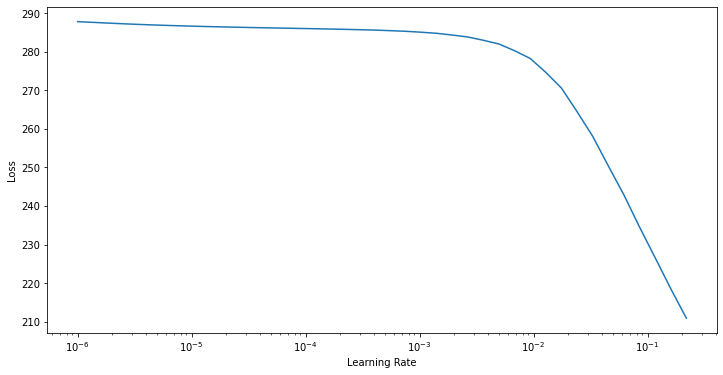

In [10]:
autoencoder.fit(x, Y, callbacks=[lr_finder,checkpoint], epochs=20, shuffle=True, batch_size=bs)

## Fitting

In [11]:
best_lr=1.e-1
optimizer=tf.keras.optimizers.SGD(lr=best_lr)
autoencoder.compile(optimizer=optimizer, loss=lossFit)

try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

hist=autoencoder.fit(x,Y,epochs=epochs,shuffle=True,callbacks=[earlystopping,checkpoint,reduce_lr], batch_size=bs)

Epoch 1/10000
10/10 [==============================] - 24s 76ms/step - loss: 133.0124
Epoch 2/10000
10/10 [==============================] - 1s 76ms/step - loss: 127.6080
Epoch 3/10000
10/10 [==============================] - 1s 65ms/step - loss: 123.3770
Epoch 4/10000
10/10 [==============================] - 1s 54ms/step - loss: 120.7253
Epoch 5/10000
10/10 [==============================] - 1s 54ms/step - loss: 117.8083
Epoch 6/10000
10/10 [==============================] - 1s 54ms/step - loss: 115.4849
Epoch 7/10000
10/10 [==============================] - 1s 54ms/step - loss: 113.2390
Epoch 8/10000
10/10 [==============================] - 1s 54ms/step - loss: 110.9592
Epoch 9/10000
10/10 [==============================] - 1s 54ms/step - loss: 108.8432
Epoch 10/10000
10/10 [==============================] - 1s 54ms/step - loss: 107.7603
Epoch 11/10000
10/10 [==============================] - 1s 55ms/step - loss: 105.8016
Epoch 12/10000
10/10 [==============================] - 1s 55m

10/10 [==============================] - 1s 59ms/step - loss: 70.7816
Epoch 98/10000
10/10 [==============================] - 1s 67ms/step - loss: 71.0182
Epoch 99/10000
10/10 [==============================] - 1s 66ms/step - loss: 70.7470
Epoch 100/10000
10/10 [==============================] - 1s 59ms/step - loss: 70.7174
Epoch 101/10000
10/10 [==============================] - 1s 68ms/step - loss: 70.5928
Epoch 102/10000
10/10 [==============================] - 1s 67ms/step - loss: 70.6904
Epoch 103/10000
10/10 [==============================] - 1s 65ms/step - loss: 70.4304
Epoch 104/10000
10/10 [==============================] - 1s 55ms/step - loss: 69.9070
Epoch 105/10000
10/10 [==============================] - 1s 68ms/step - loss: 69.5180
Epoch 106/10000
10/10 [==============================] - 1s 71ms/step - loss: 69.2138
Epoch 107/10000
10/10 [==============================] - 1s 66ms/step - loss: 69.7039
Epoch 108/10000
10/10 [==============================] - 1s 67ms/step - 

10/10 [==============================] - 1s 68ms/step - loss: 61.9895
Epoch 193/10000
10/10 [==============================] - 1s 65ms/step - loss: 62.6383
Epoch 194/10000
10/10 [==============================] - 1s 67ms/step - loss: 61.7401
Epoch 195/10000
10/10 [==============================] - 1s 66ms/step - loss: 62.8815
Epoch 196/10000
10/10 [==============================] - 1s 66ms/step - loss: 61.8356
Epoch 197/10000
10/10 [==============================] - 1s 68ms/step - loss: 61.5747
Epoch 198/10000
10/10 [==============================] - 1s 67ms/step - loss: 61.9584
Epoch 199/10000
10/10 [==============================] - 1s 66ms/step - loss: 61.6733
Epoch 200/10000
10/10 [==============================] - 1s 67ms/step - loss: 62.6828
Epoch 201/10000
10/10 [==============================] - 1s 65ms/step - loss: 61.7732
Epoch 202/10000
10/10 [==============================] - 1s 67ms/step - loss: 60.9666
Epoch 203/10000
10/10 [==============================] - 1s 66ms/step 

10/10 [==============================] - 1s 66ms/step - loss: 58.2635
Epoch 288/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.5639
Epoch 289/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.4940
Epoch 290/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.1603
Epoch 291/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.7811
Epoch 292/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.2656
Epoch 293/10000
10/10 [==============================] - 1s 67ms/step - loss: 58.2368
Epoch 294/10000
10/10 [==============================] - 1s 67ms/step - loss: 58.1639
Epoch 295/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.4640
Epoch 296/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.5695
Epoch 297/10000
10/10 [==============================] - 1s 66ms/step - loss: 58.4221
Epoch 298/10000
10/10 [==============================] - 1s 66ms/step 

10/10 [==============================] - 1s 77ms/step - loss: 52.5829
Epoch 383/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.6104
Epoch 384/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.5506
Epoch 385/10000
10/10 [==============================] - 1s 77ms/step - loss: 52.5765
Epoch 386/10000
10/10 [==============================] - 1s 77ms/step - loss: 52.6782
Epoch 387/10000
10/10 [==============================] - 1s 77ms/step - loss: 52.7351
Epoch 388/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.6337
Epoch 389/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.4357
Epoch 390/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.6368
Epoch 391/10000
10/10 [==============================] - 1s 77ms/step - loss: 52.5883
Epoch 392/10000
10/10 [==============================] - 1s 78ms/step - loss: 52.3900
Epoch 393/10000
10/10 [==============================] - 1s 78ms/step 

10/10 [==============================] - 1s 78ms/step - loss: 51.6724
Epoch 478/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.7573
Epoch 479/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.6860
Epoch 480/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.8268
Epoch 481/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.7618
Epoch 482/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.6533
Epoch 483/10000
10/10 [==============================] - 1s 79ms/step - loss: 51.6264
Epoch 484/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.7683
Epoch 485/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.4534
Epoch 486/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.7936
Epoch 487/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.4857
Epoch 488/10000
10/10 [==============================] - 1s 78ms/step 

10/10 [==============================] - 1s 78ms/step - loss: 51.1928
Epoch 573/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.2585
Epoch 574/10000
10/10 [==============================] - 1s 79ms/step - loss: 51.2029
Epoch 575/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.2083
Epoch 576/10000
10/10 [==============================] - 1s 77ms/step - loss: 51.0511
Epoch 577/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.1240
Epoch 578/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.0265
Epoch 579/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.9571
Epoch 580/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.1095
Epoch 581/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.8757
Epoch 582/10000
10/10 [==============================] - 1s 78ms/step - loss: 51.0810
Epoch 583/10000
10/10 [==============================] - 1s 79ms/step 

10/10 [==============================] - 1s 77ms/step - loss: 50.6385
Epoch 668/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.5581
Epoch 669/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.8302
Epoch 670/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.4915
Epoch 671/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.5070
Epoch 672/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.5171
Epoch 673/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.6717
Epoch 674/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.6764
Epoch 675/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.7424
Epoch 676/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.4353
Epoch 677/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.5053
Epoch 678/10000
10/10 [==============================] - 1s 73ms/step 

10/10 [==============================] - 1s 78ms/step - loss: 50.0192
Epoch 763/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.3138
Epoch 764/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.0556
Epoch 765/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.2750
Epoch 766/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.1869
Epoch 767/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.2756
Epoch 768/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.0920
Epoch 769/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.4211
Epoch 770/10000
10/10 [==============================] - 1s 78ms/step - loss: 50.2185
Epoch 771/10000
10/10 [==============================] - 1s 67ms/step - loss: 50.3123
Epoch 772/10000
10/10 [==============================] - 1s 77ms/step - loss: 50.1370
Epoch 773/10000
10/10 [==============================] - 1s 78ms/step 

10/10 [==============================] - 1s 56ms/step - loss: 49.9356
Epoch 858/10000
10/10 [==============================] - 1s 62ms/step - loss: 49.8946
Epoch 859/10000
10/10 [==============================] - 1s 66ms/step - loss: 50.0589
Epoch 860/10000
10/10 [==============================] - 1s 59ms/step - loss: 49.8249
Epoch 861/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.9107
Epoch 862/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.8430
Epoch 863/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.8907
Epoch 864/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.9051
Epoch 865/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.8598
Epoch 866/10000
10/10 [==============================] - 1s 51ms/step - loss: 49.9531
Epoch 867/10000
10/10 [==============================] - 1s 52ms/step - loss: 49.9328
Epoch 868/10000
10/10 [==============================] - 1s 52ms/step 

10/10 [==============================] - 1s 77ms/step - loss: 49.4281
Epoch 953/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.5881
Epoch 954/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.3576
Epoch 955/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.5920
Epoch 956/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.3835
Epoch 957/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.6870
Epoch 958/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.5209
Epoch 959/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.6205
Epoch 960/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.6651
Epoch 961/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.5634
Epoch 962/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.6610
Epoch 963/10000
10/10 [==============================] - 1s 77ms/step 

10/10 [==============================] - 1s 77ms/step - loss: 49.5500
Epoch 1047/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.3307
Epoch 1048/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.4218
Epoch 1049/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.3318
Epoch 1050/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.4365
Epoch 1051/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.3743
Epoch 1052/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.1697
Epoch 1053/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.4544
Epoch 1054/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1385
Epoch 1055/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.3855
Epoch 1056/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.3247
Epoch 1057/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 78ms/step - loss: 49.0480
Epoch 1141/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.2381
Epoch 1142/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.0054
Epoch 1143/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1281
Epoch 1144/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.2261
Epoch 1145/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1541
Epoch 1146/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1923
Epoch 1147/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.0993
Epoch 1148/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.2603
Epoch 1149/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.0686
Epoch 1150/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1990
Epoch 1151/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 78ms/step - loss: 48.9431
Epoch 1235/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.9361
Epoch 1236/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1050
Epoch 1237/10000
10/10 [==============================] - 1s 78ms/step - loss: 48.8773
Epoch 1238/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.0931
Epoch 1239/10000
10/10 [==============================] - 1s 78ms/step - loss: 48.9417
Epoch 1240/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.1522
Epoch 1241/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.1052
Epoch 1242/10000
10/10 [==============================] - 1s 78ms/step - loss: 48.9518
Epoch 1243/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.0383
Epoch 1244/10000
10/10 [==============================] - 1s 78ms/step - loss: 49.0903
Epoch 1245/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 78ms/step - loss: 48.9369
Epoch 1329/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.8069
Epoch 1330/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.8945
Epoch 1331/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.8733
Epoch 1332/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.8690
Epoch 1333/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.9195
Epoch 1334/10000
10/10 [==============================] - 1s 77ms/step - loss: 49.0006
Epoch 1335/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.8424
Epoch 1336/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.9718
Epoch 1337/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.9454
Epoch 1338/10000
10/10 [==============================] - 1s 77ms/step - loss: 48.7414
Epoch 1339/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.7546
Epoch 1423/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.8911
Epoch 1424/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.6774
Epoch 1425/10000
10/10 [==============================] - 1s 72ms/step - loss: 48.7684
Epoch 1426/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.6715
Epoch 1427/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.7893
Epoch 1428/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.6801
Epoch 1429/10000
10/10 [==============================] - 1s 64ms/step - loss: 48.7369
Epoch 1430/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.7078
Epoch 1431/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.5495
Epoch 1432/10000
10/10 [==============================] - 1s 55ms/step - loss: 48.8625
Epoch 1433/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 48.4206
Epoch 1517/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2947
Epoch 1518/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.4016
Epoch 1519/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4065
Epoch 1520/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3639
Epoch 1521/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3388
Epoch 1522/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2385
Epoch 1523/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3309
Epoch 1524/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4805
Epoch 1525/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.4959
Epoch 1526/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3399
Epoch 1527/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.5007
Epoch 1611/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2046
Epoch 1612/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4419
Epoch 1613/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2892
Epoch 1614/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4485
Epoch 1615/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.3009
Epoch 1616/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2925
Epoch 1617/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2830
Epoch 1618/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3731
Epoch 1619/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4461
Epoch 1620/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3629
Epoch 1621/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.3429
Epoch 1705/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.3556
Epoch 1706/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4407
Epoch 1707/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3475
Epoch 1708/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2691
Epoch 1709/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3967
Epoch 1710/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3014
Epoch 1711/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2687
Epoch 1712/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.1612
Epoch 1713/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3479
Epoch 1714/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4299
Epoch 1715/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.3301
Epoch 1799/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3945
Epoch 1800/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3827
Epoch 1801/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.4582
Epoch 1802/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2196
Epoch 1803/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0940
Epoch 1804/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3376
Epoch 1805/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0486
Epoch 1806/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2437
Epoch 1807/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3798
Epoch 1808/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0798
Epoch 1809/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.2807
Epoch 1893/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.2361
Epoch 1894/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2591
Epoch 1895/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2920
Epoch 1896/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3740
Epoch 1897/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2981
Epoch 1898/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2462
Epoch 1899/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2262
Epoch 1900/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1599
Epoch 1901/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3327
Epoch 1902/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2300
Epoch 1903/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.3182
Epoch 1987/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3118
Epoch 1988/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3018
Epoch 1989/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0600
Epoch 1990/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3900
Epoch 1991/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3607
Epoch 1992/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3295
Epoch 1993/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2657
Epoch 1994/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3726
Epoch 1995/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3231
Epoch 1996/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1002
Epoch 1997/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.2067
Epoch 2081/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2521
Epoch 2082/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2143
Epoch 2083/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1541
Epoch 2084/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2391
Epoch 2085/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1988
Epoch 2086/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1766
Epoch 2087/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0335
Epoch 2088/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2768
Epoch 2089/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3115
Epoch 2090/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0902
Epoch 2091/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.3196
Epoch 2175/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2847
Epoch 2176/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1775
Epoch 2177/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0532
Epoch 2178/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1308
Epoch 2179/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2886
Epoch 2180/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2023
Epoch 2181/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1488
Epoch 2182/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1489
Epoch 2183/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2023
Epoch 2184/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1014
Epoch 2185/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.1030
Epoch 2269/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1349
Epoch 2270/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.2231
Epoch 2271/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2284
Epoch 2272/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2462
Epoch 2273/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2013
Epoch 2274/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1914
Epoch 2275/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.1507
Epoch 2276/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.3064
Epoch 2277/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1044
Epoch 2278/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2368
Epoch 2279/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.0689
Epoch 2363/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0719
Epoch 2364/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2188
Epoch 2365/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1706
Epoch 2366/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0799
Epoch 2367/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1731
Epoch 2368/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2215
Epoch 2369/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2043
Epoch 2370/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2133
Epoch 2371/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.2652
Epoch 2372/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0870
Epoch 2373/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.3318
Epoch 2457/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0173
Epoch 2458/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9813
Epoch 2459/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0697
Epoch 2460/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1688
Epoch 2461/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1123
Epoch 2462/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1656
Epoch 2463/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1744
Epoch 2464/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1343
Epoch 2465/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1309
Epoch 2466/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1407
Epoch 2467/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 51ms/step - loss: 48.1500
Epoch 2551/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1405
Epoch 2552/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2126
Epoch 2553/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1382
Epoch 2554/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0488
Epoch 2555/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2225
Epoch 2556/10000
10/10 [==============================] - 1s 51ms/step - loss: 48.1472
Epoch 2557/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2586
Epoch 2558/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0393
Epoch 2559/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0720
Epoch 2560/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0823
Epoch 2561/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.0626
Epoch 2645/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2660
Epoch 2646/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9947
Epoch 2647/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1238
Epoch 2648/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0614
Epoch 2649/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1606
Epoch 2650/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1375
Epoch 2651/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0326
Epoch 2652/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0657
Epoch 2653/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0668
Epoch 2654/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1495
Epoch 2655/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.9903
Epoch 2739/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0064
Epoch 2740/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0718
Epoch 2741/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1347
Epoch 2742/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9884
Epoch 2743/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1566
Epoch 2744/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9478
Epoch 2745/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1549
Epoch 2746/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0611
Epoch 2747/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.9087
Epoch 2748/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1076
Epoch 2749/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.9480
Epoch 2833/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0289
Epoch 2834/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0574
Epoch 2835/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2146
Epoch 2836/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.1506
Epoch 2837/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0787
Epoch 2838/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9051
Epoch 2839/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1454
Epoch 2840/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1418
Epoch 2841/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.2930
Epoch 2842/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1134
Epoch 2843/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.0372
Epoch 2927/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9918
Epoch 2928/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9636
Epoch 2929/10000
10/10 [==============================] - 1s 55ms/step - loss: 48.1376
Epoch 2930/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9030
Epoch 2931/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9485
Epoch 2932/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9680
Epoch 2933/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.2737
Epoch 2934/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1531
Epoch 2935/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0246
Epoch 2936/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9897
Epoch 2937/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 48.0237
Epoch 3021/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0579
Epoch 3022/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0031
Epoch 3023/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0855
Epoch 3024/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9800
Epoch 3025/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.1038
Epoch 3026/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9982
Epoch 3027/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1036
Epoch 3028/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0313
Epoch 3029/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0054
Epoch 3030/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.9323
Epoch 3031/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.9374
Epoch 3115/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9365
Epoch 3116/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9843
Epoch 3117/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9292
Epoch 3118/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1114
Epoch 3119/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0128
Epoch 3120/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8990
Epoch 3121/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8843
Epoch 3122/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8752
Epoch 3123/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0842
Epoch 3124/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9842
Epoch 3125/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 48.0941
Epoch 3209/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9672
Epoch 3210/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9927
Epoch 3211/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0452
Epoch 3212/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0202
Epoch 3213/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.9444
Epoch 3214/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0117
Epoch 3215/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9783
Epoch 3216/10000
10/10 [==============================] - 1s 55ms/step - loss: 48.0242
Epoch 3217/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0272
Epoch 3218/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9010
Epoch 3219/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 48.0376
Epoch 3303/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8786
Epoch 3304/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9579
Epoch 3305/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0091
Epoch 3306/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9447
Epoch 3307/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8742
Epoch 3308/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0265
Epoch 3309/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1128
Epoch 3310/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9440
Epoch 3311/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9835
Epoch 3312/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0270
Epoch 3313/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.9988
Epoch 3397/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9192
Epoch 3398/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0021
Epoch 3399/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0381
Epoch 3400/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0458
Epoch 3401/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8963
Epoch 3402/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8765
Epoch 3403/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8884
Epoch 3404/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.9862
Epoch 3405/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9819
Epoch 3406/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9860
Epoch 3407/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.8877
Epoch 3491/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8939
Epoch 3492/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9998
Epoch 3493/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0004
Epoch 3494/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9013
Epoch 3495/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9726
Epoch 3496/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.9330
Epoch 3497/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8651
Epoch 3498/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9629
Epoch 3499/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0535
Epoch 3500/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7929
Epoch 3501/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.9652
Epoch 3585/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9820
Epoch 3586/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9250
Epoch 3587/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9672
Epoch 3588/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9540
Epoch 3589/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9698
Epoch 3590/10000
10/10 [==============================] - 1s 54ms/step - loss: 48.0665
Epoch 3591/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9620
Epoch 3592/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8951
Epoch 3593/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0555
Epoch 3594/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9507
Epoch 3595/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.9222
Epoch 3679/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8565
Epoch 3680/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9279
Epoch 3681/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8482
Epoch 3682/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9106
Epoch 3683/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.9309
Epoch 3684/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8581
Epoch 3685/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.0429
Epoch 3686/10000
10/10 [==============================] - 1s 53ms/step - loss: 48.0353
Epoch 3687/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.9692
Epoch 3688/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8316
Epoch 3689/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.9756
Epoch 3773/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8477
Epoch 3774/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8004
Epoch 3775/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8600
Epoch 3776/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8990
Epoch 3777/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9387
Epoch 3778/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9606
Epoch 3779/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9910
Epoch 3780/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9255
Epoch 3781/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8444
Epoch 3782/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8092
Epoch 3783/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.8673
Epoch 3867/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8745
Epoch 3868/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9143
Epoch 3869/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.9569
Epoch 3870/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8804
Epoch 3871/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.9105
Epoch 3872/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8888
Epoch 3873/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9124
Epoch 3874/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8050
Epoch 3875/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.9058
Epoch 3876/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8359
Epoch 3877/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.9247
Epoch 3961/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8561
Epoch 3962/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7872
Epoch 3963/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9468
Epoch 3964/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7926
Epoch 3965/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5646
Epoch 3966/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9092
Epoch 3967/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9054
Epoch 3968/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6421
Epoch 3969/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8334
Epoch 3970/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8193
Epoch 3971/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.7683
Epoch 4055/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8443
Epoch 4056/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8394
Epoch 4057/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7751
Epoch 4058/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7240
Epoch 4059/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7664
Epoch 4060/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.9546
Epoch 4061/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9705
Epoch 4062/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7721
Epoch 4063/10000
10/10 [==============================] - 1s 52ms/step - loss: 48.1365
Epoch 4064/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.9525
Epoch 4065/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.9239
Epoch 4149/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8673
Epoch 4150/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6797
Epoch 4151/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8746
Epoch 4152/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.6854
Epoch 4153/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9127
Epoch 4154/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7701
Epoch 4155/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8230
Epoch 4156/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7402
Epoch 4157/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.7965
Epoch 4158/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8992
Epoch 4159/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.7626
Epoch 4243/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.9472
Epoch 4244/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.7617
Epoch 4245/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7337
Epoch 4246/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9418
Epoch 4247/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7102
Epoch 4248/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7687
Epoch 4249/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.6797
Epoch 4250/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7865
Epoch 4251/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7885
Epoch 4252/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7473
Epoch 4253/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.8176
Epoch 4337/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7715
Epoch 4338/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5825
Epoch 4339/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9271
Epoch 4340/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.9430
Epoch 4341/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.7651
Epoch 4342/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7932
Epoch 4343/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7827
Epoch 4344/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7744
Epoch 4345/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7609
Epoch 4346/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7660
Epoch 4347/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.8825
Epoch 4431/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7896
Epoch 4432/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.6639
Epoch 4433/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.8306
Epoch 4434/10000
10/10 [==============================] - 1s 58ms/step - loss: 47.7208
Epoch 4435/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.5755
Epoch 4436/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.5832
Epoch 4437/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9172
Epoch 4438/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7356
Epoch 4439/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7798
Epoch 4440/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7097
Epoch 4441/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.7866
Epoch 4525/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.8325
Epoch 4526/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7675
Epoch 4527/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.8196
Epoch 4528/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.8481
Epoch 4529/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7470
Epoch 4530/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7690
Epoch 4531/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7927
Epoch 4532/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.7872
Epoch 4533/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7023
Epoch 4534/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.6377
Epoch 4535/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.7660
Epoch 4619/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.7886
Epoch 4620/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.6836
Epoch 4621/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.6633
Epoch 4622/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.7802
Epoch 4623/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6941
Epoch 4624/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7583
Epoch 4625/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.8500
Epoch 4626/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.8022
Epoch 4627/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.8449
Epoch 4628/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6575
Epoch 4629/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.7241
Epoch 4713/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6817
Epoch 4714/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.7366
Epoch 4715/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5743
Epoch 4716/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.8913
Epoch 4717/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6285
Epoch 4718/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7657
Epoch 4719/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7869
Epoch 4720/10000
10/10 [==============================] - 1s 61ms/step - loss: 47.7199
Epoch 4721/10000
10/10 [==============================] - 1s 60ms/step - loss: 47.6954
Epoch 4722/10000
10/10 [==============================] - 1s 61ms/step - loss: 47.6945
Epoch 4723/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.7129
Epoch 4807/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8492
Epoch 4808/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7525
Epoch 4809/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6339
Epoch 4810/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6722
Epoch 4811/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7179
Epoch 4812/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6925
Epoch 4813/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7937
Epoch 4814/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7436
Epoch 4815/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7497
Epoch 4816/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7237
Epoch 4817/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.7377
Epoch 4901/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7163
Epoch 4902/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8891
Epoch 4903/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6182
Epoch 4904/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6704
Epoch 4905/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7545
Epoch 4906/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8237
Epoch 4907/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6964
Epoch 4908/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6164
Epoch 4909/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6528
Epoch 4910/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7185
Epoch 4911/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.7282
Epoch 4995/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6662
Epoch 4996/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4961
Epoch 4997/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6256
Epoch 4998/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8262
Epoch 4999/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7036
Epoch 5000/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6803
Epoch 5001/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.7096
Epoch 5002/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6656
Epoch 5003/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7293
Epoch 5004/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5444
Epoch 5005/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6445
Epoch 5089/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7465
Epoch 5090/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7509
Epoch 5091/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7662
Epoch 5092/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7254
Epoch 5093/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.9018
Epoch 5094/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8047
Epoch 5095/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7438
Epoch 5096/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6471
Epoch 5097/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7132
Epoch 5098/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7970
Epoch 5099/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.7086
Epoch 5183/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5970
Epoch 5184/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7240
Epoch 5185/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6719
Epoch 5186/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6411
Epoch 5187/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6107
Epoch 5188/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6380
Epoch 5189/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6466
Epoch 5190/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.8314
Epoch 5191/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7411
Epoch 5192/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6338
Epoch 5193/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6521
Epoch 5277/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7339
Epoch 5278/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5191
Epoch 5279/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6514
Epoch 5280/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5875
Epoch 5281/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6165
Epoch 5282/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6283
Epoch 5283/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5219
Epoch 5284/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7106
Epoch 5285/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6907
Epoch 5286/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6618
Epoch 5287/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6341
Epoch 5371/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6417
Epoch 5372/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5532
Epoch 5373/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6402
Epoch 5374/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.7698
Epoch 5375/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7074
Epoch 5376/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6531
Epoch 5377/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6105
Epoch 5378/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6285
Epoch 5379/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6549
Epoch 5380/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5864
Epoch 5381/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6880
Epoch 5465/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5369
Epoch 5466/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6000
Epoch 5467/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6817
Epoch 5468/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5351
Epoch 5469/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7347
Epoch 5470/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7457
Epoch 5471/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7294
Epoch 5472/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5947
Epoch 5473/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6899
Epoch 5474/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5536
Epoch 5475/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4457
Epoch 5559/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5677
Epoch 5560/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6450
Epoch 5561/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6726
Epoch 5562/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6622
Epoch 5563/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5716
Epoch 5564/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6399
Epoch 5565/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5546
Epoch 5566/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6216
Epoch 5567/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6707
Epoch 5568/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7442
Epoch 5569/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4683
Epoch 5653/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5040
Epoch 5654/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6377
Epoch 5655/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5875
Epoch 5656/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5993
Epoch 5657/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6428
Epoch 5658/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6751
Epoch 5659/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5665
Epoch 5660/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6093
Epoch 5661/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5290
Epoch 5662/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5720
Epoch 5663/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6107
Epoch 5747/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7053
Epoch 5748/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5418
Epoch 5749/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5528
Epoch 5750/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5388
Epoch 5751/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5504
Epoch 5752/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7281
Epoch 5753/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6444
Epoch 5754/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4513
Epoch 5755/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5695
Epoch 5756/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7219
Epoch 5757/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5906
Epoch 5841/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6652
Epoch 5842/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5409
Epoch 5843/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7294
Epoch 5844/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6146
Epoch 5845/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5160
Epoch 5846/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6005
Epoch 5847/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6229
Epoch 5848/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5296
Epoch 5849/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6488
Epoch 5850/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7161
Epoch 5851/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6728
Epoch 5935/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5574
Epoch 5936/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6233
Epoch 5937/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5711
Epoch 5938/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5808
Epoch 5939/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5280
Epoch 5940/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5199
Epoch 5941/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5255
Epoch 5942/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5336
Epoch 5943/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5682
Epoch 5944/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5237
Epoch 5945/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5617
Epoch 6029/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4970
Epoch 6030/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6246
Epoch 6031/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.7039
Epoch 6032/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5992
Epoch 6033/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6010
Epoch 6034/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5212
Epoch 6035/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6358
Epoch 6036/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6312
Epoch 6037/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6255
Epoch 6038/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4823
Epoch 6039/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 51ms/step - loss: 47.5066
Epoch 6123/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5622
Epoch 6124/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6100
Epoch 6125/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5644
Epoch 6126/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5346
Epoch 6127/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6065
Epoch 6128/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4467
Epoch 6129/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4932
Epoch 6130/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5747
Epoch 6131/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6529
Epoch 6132/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.6780
Epoch 6133/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4747
Epoch 6217/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5469
Epoch 6218/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5483
Epoch 6219/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4556
Epoch 6220/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4311
Epoch 6221/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.6737
Epoch 6222/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5633
Epoch 6223/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3848
Epoch 6224/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4560
Epoch 6225/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.5448
Epoch 6226/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.5397
Epoch 6227/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.6154
Epoch 6311/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5304
Epoch 6312/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2461
Epoch 6313/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4550
Epoch 6314/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5574
Epoch 6315/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5478
Epoch 6316/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4450
Epoch 6317/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6985
Epoch 6318/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5031
Epoch 6319/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3311
Epoch 6320/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4493
Epoch 6321/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4520
Epoch 6405/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5382
Epoch 6406/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4696
Epoch 6407/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4612
Epoch 6408/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3832
Epoch 6409/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3136
Epoch 6410/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6301
Epoch 6411/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4322
Epoch 6412/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5046
Epoch 6413/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.5227
Epoch 6414/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4890
Epoch 6415/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5909
Epoch 6499/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6298
Epoch 6500/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3015
Epoch 6501/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5204
Epoch 6502/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5891
Epoch 6503/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6347
Epoch 6504/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4864
Epoch 6505/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5398
Epoch 6506/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6401
Epoch 6507/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3875
Epoch 6508/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5085
Epoch 6509/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4818
Epoch 6593/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4768
Epoch 6594/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4176
Epoch 6595/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5406
Epoch 6596/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4007
Epoch 6597/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.5566
Epoch 6598/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2624
Epoch 6599/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4760
Epoch 6600/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3810
Epoch 6601/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4688
Epoch 6602/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3520
Epoch 6603/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5124
Epoch 6687/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5563
Epoch 6688/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3948
Epoch 6689/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5288
Epoch 6690/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5202
Epoch 6691/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5254
Epoch 6692/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4538
Epoch 6693/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4853
Epoch 6694/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5363
Epoch 6695/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4280
Epoch 6696/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5559
Epoch 6697/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4378
Epoch 6781/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3714
Epoch 6782/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3893
Epoch 6783/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4289
Epoch 6784/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5970
Epoch 6785/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4135
Epoch 6786/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3541
Epoch 6787/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4641
Epoch 6788/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4255
Epoch 6789/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3110
Epoch 6790/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5292
Epoch 6791/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4255
Epoch 6875/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3871
Epoch 6876/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4502
Epoch 6877/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.6324
Epoch 6878/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5602
Epoch 6879/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5556
Epoch 6880/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4563
Epoch 6881/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4209
Epoch 6882/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5743
Epoch 6883/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4209
Epoch 6884/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4626
Epoch 6885/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.2175
Epoch 6969/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4913
Epoch 6970/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2996
Epoch 6971/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5813
Epoch 6972/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4308
Epoch 6973/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3750
Epoch 6974/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3926
Epoch 6975/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5483
Epoch 6976/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4611
Epoch 6977/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.4393
Epoch 6978/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.5564
Epoch 6979/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5111
Epoch 7063/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4336
Epoch 7064/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4159
Epoch 7065/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.5598
Epoch 7066/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4812
Epoch 7067/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3175
Epoch 7068/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4020
Epoch 7069/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4481
Epoch 7070/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3747
Epoch 7071/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2971
Epoch 7072/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.4652
Epoch 7073/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3617
Epoch 7157/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4094
Epoch 7158/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3265
Epoch 7159/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3675
Epoch 7160/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4264
Epoch 7161/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4011
Epoch 7162/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3025
Epoch 7163/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3976
Epoch 7164/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.4669
Epoch 7165/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4299
Epoch 7166/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2867
Epoch 7167/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3441
Epoch 7251/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3819
Epoch 7252/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4495
Epoch 7253/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3747
Epoch 7254/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3583
Epoch 7255/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4080
Epoch 7256/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4076
Epoch 7257/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3789
Epoch 7258/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5332
Epoch 7259/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3495
Epoch 7260/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4758
Epoch 7261/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4363
Epoch 7345/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3902
Epoch 7346/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4399
Epoch 7347/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4229
Epoch 7348/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4057
Epoch 7349/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4132
Epoch 7350/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3505
Epoch 7351/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3691
Epoch 7352/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4248
Epoch 7353/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3143
Epoch 7354/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.4257
Epoch 7355/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.5332
Epoch 7439/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3783
Epoch 7440/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4077
Epoch 7441/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3906
Epoch 7442/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3527
Epoch 7443/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3982
Epoch 7444/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2285
Epoch 7445/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3257
Epoch 7446/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3773
Epoch 7447/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4169
Epoch 7448/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4204
Epoch 7449/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3223
Epoch 7533/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2731
Epoch 7534/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3795
Epoch 7535/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2562
Epoch 7536/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3878
Epoch 7537/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4001
Epoch 7538/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2937
Epoch 7539/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3502
Epoch 7540/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4297
Epoch 7541/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4222
Epoch 7542/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.4445
Epoch 7543/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4100
Epoch 7627/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.4731
Epoch 7628/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3525
Epoch 7629/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3439
Epoch 7630/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2720
Epoch 7631/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5186
Epoch 7632/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3350
Epoch 7633/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3089
Epoch 7634/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4109
Epoch 7635/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4661
Epoch 7636/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3835
Epoch 7637/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3595
Epoch 7721/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3895
Epoch 7722/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3605
Epoch 7723/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3054
Epoch 7724/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4679
Epoch 7725/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2602
Epoch 7726/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3090
Epoch 7727/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1577
Epoch 7728/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4443
Epoch 7729/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2831
Epoch 7730/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4188
Epoch 7731/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3390
Epoch 7815/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2848
Epoch 7816/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2637
Epoch 7817/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3056
Epoch 7818/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2886
Epoch 7819/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2480
Epoch 7820/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.4159
Epoch 7821/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3166
Epoch 7822/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3410
Epoch 7823/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.3676
Epoch 7824/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3279
Epoch 7825/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3421
Epoch 7909/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3180
Epoch 7910/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3568
Epoch 7911/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3404
Epoch 7912/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5322
Epoch 7913/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2940
Epoch 7914/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3406
Epoch 7915/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4649
Epoch 7916/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3326
Epoch 7917/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3512
Epoch 7918/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3163
Epoch 7919/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3209
Epoch 8003/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2478
Epoch 8004/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.5019
Epoch 8005/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3309
Epoch 8006/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4693
Epoch 8007/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3477
Epoch 8008/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2839
Epoch 8009/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2900
Epoch 8010/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2944
Epoch 8011/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3004
Epoch 8012/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3322
Epoch 8013/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.4591
Epoch 8097/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1683
Epoch 8098/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3315
Epoch 8099/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4235
Epoch 8100/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3832
Epoch 8101/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3342
Epoch 8102/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3450
Epoch 8103/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3303
Epoch 8104/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.4415
Epoch 8105/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2105
Epoch 8106/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3627
Epoch 8107/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3311
Epoch 8191/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2285
Epoch 8192/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3270
Epoch 8193/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3010
Epoch 8194/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3756
Epoch 8195/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3696
Epoch 8196/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3515
Epoch 8197/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3185
Epoch 8198/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3975
Epoch 8199/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3799
Epoch 8200/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2271
Epoch 8201/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.3378
Epoch 8285/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3074
Epoch 8286/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3004
Epoch 8287/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3608
Epoch 8288/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2517
Epoch 8289/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.4424
Epoch 8290/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2585
Epoch 8291/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3837
Epoch 8292/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2886
Epoch 8293/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3581
Epoch 8294/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4197
Epoch 8295/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.1857
Epoch 8379/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3421
Epoch 8380/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3723
Epoch 8381/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2817
Epoch 8382/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1877
Epoch 8383/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2299
Epoch 8384/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.4615
Epoch 8385/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2652
Epoch 8386/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3651
Epoch 8387/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.4723
Epoch 8388/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2540
Epoch 8389/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.3373
Epoch 8473/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2272
Epoch 8474/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2085
Epoch 8475/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2008
Epoch 8476/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2776
Epoch 8477/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1939
Epoch 8478/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2423
Epoch 8479/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2088
Epoch 8480/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2886
Epoch 8481/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3359
Epoch 8482/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2343
Epoch 8483/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.1976
Epoch 8567/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2343
Epoch 8568/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1323
Epoch 8569/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2846
Epoch 8570/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3445
Epoch 8571/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3500
Epoch 8572/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2414
Epoch 8573/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2904
Epoch 8574/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3489
Epoch 8575/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2836
Epoch 8576/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2959
Epoch 8577/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3355
Epoch 8661/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1675
Epoch 8662/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1847
Epoch 8663/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2940
Epoch 8664/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2613
Epoch 8665/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2938
Epoch 8666/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2775
Epoch 8667/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2545
Epoch 8668/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3961
Epoch 8669/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1853
Epoch 8670/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3587
Epoch 8671/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.3066
Epoch 8755/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3445
Epoch 8756/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2834
Epoch 8757/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2482
Epoch 8758/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3404
Epoch 8759/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2931
Epoch 8760/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2725
Epoch 8761/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.3151
Epoch 8762/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3005
Epoch 8763/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2151
Epoch 8764/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2567
Epoch 8765/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.3106
Epoch 8849/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2216
Epoch 8850/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2533
Epoch 8851/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3079
Epoch 8852/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2563
Epoch 8853/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2629
Epoch 8854/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2379
Epoch 8855/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3578
Epoch 8856/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2289
Epoch 8857/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2599
Epoch 8858/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2048
Epoch 8859/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.1443
Epoch 8943/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3524
Epoch 8944/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1663
Epoch 8945/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2861
Epoch 8946/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1634
Epoch 8947/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2341
Epoch 8948/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2287
Epoch 8949/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1389
Epoch 8950/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1482
Epoch 8951/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2979
Epoch 8952/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.0714
Epoch 8953/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.1715
Epoch 9037/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2338
Epoch 9038/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2587
Epoch 9039/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1386
Epoch 9040/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1957
Epoch 9041/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2467
Epoch 9042/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1810
Epoch 9043/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.3051
Epoch 9044/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1877
Epoch 9045/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3119
Epoch 9046/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2973
Epoch 9047/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.2473
Epoch 9131/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2823
Epoch 9132/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.2811
Epoch 9133/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1842
Epoch 9134/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1536
Epoch 9135/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2447
Epoch 9136/10000
10/10 [==============================] - 1s 51ms/step - loss: 47.3052
Epoch 9137/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1375
Epoch 9138/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2455
Epoch 9139/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3564
Epoch 9140/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3633
Epoch 9141/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 52ms/step - loss: 47.3016
Epoch 9225/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2622
Epoch 9226/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1988
Epoch 9227/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2432
Epoch 9228/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1996
Epoch 9229/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2141
Epoch 9230/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2128
Epoch 9231/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2394
Epoch 9232/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1557
Epoch 9233/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2827
Epoch 9234/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2140
Epoch 9235/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.2523
Epoch 9319/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3948
Epoch 9320/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.3018
Epoch 9321/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.3649
Epoch 9322/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1905
Epoch 9323/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2367
Epoch 9324/10000
10/10 [==============================] - 1s 63ms/step - loss: 47.2029
Epoch 9325/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2906
Epoch 9326/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2200
Epoch 9327/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1892
Epoch 9328/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.3589
Epoch 9329/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.2868
Epoch 9413/10000
10/10 [==============================] - 1s 52ms/step - loss: 46.9994
Epoch 9414/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1822
Epoch 9415/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1475
Epoch 9416/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2326
Epoch 9417/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1079
Epoch 9418/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.0738
Epoch 9419/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.0784
Epoch 9420/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1884
Epoch 9421/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2609
Epoch 9422/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2259
Epoch 9423/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 53ms/step - loss: 47.1613
Epoch 9507/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.3509
Epoch 9508/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2527
Epoch 9509/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1505
Epoch 9510/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2686
Epoch 9511/10000
10/10 [==============================] - 1s 58ms/step - loss: 47.2328
Epoch 9512/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1876
Epoch 9513/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1379
Epoch 9514/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1836
Epoch 9515/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2447
Epoch 9516/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1404
Epoch 9517/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.2393
Epoch 9601/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1715
Epoch 9602/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.2147
Epoch 9603/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2435
Epoch 9604/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.2520
Epoch 9605/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.4089
Epoch 9606/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1361
Epoch 9607/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1327
Epoch 9608/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1606
Epoch 9609/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2248
Epoch 9610/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.1178
Epoch 9611/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 55ms/step - loss: 47.1922
Epoch 9695/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1700
Epoch 9696/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2161
Epoch 9697/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1757
Epoch 9698/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1985
Epoch 9699/10000
10/10 [==============================] - 1s 61ms/step - loss: 47.0603
Epoch 9700/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1672
Epoch 9701/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.2824
Epoch 9702/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1205
Epoch 9703/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3037
Epoch 9704/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1240
Epoch 9705/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.1990
Epoch 9789/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1592
Epoch 9790/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2542
Epoch 9791/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.1380
Epoch 9792/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.0742
Epoch 9793/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1117
Epoch 9794/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1752
Epoch 9795/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.2618
Epoch 9796/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.1213
Epoch 9797/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.0218
Epoch 9798/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1060
Epoch 9799/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.0794
Epoch 9883/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.3003
Epoch 9884/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.0763
Epoch 9885/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1931
Epoch 9886/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.1435
Epoch 9887/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1314
Epoch 9888/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.0295
Epoch 9889/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.0218
Epoch 9890/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1868
Epoch 9891/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1644
Epoch 9892/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1947
Epoch 9893/10000
10/10 [==============================] - 1s

10/10 [==============================] - 1s 54ms/step - loss: 47.1516
Epoch 9977/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2453
Epoch 9978/10000
10/10 [==============================] - 1s 58ms/step - loss: 47.1421
Epoch 9979/10000
10/10 [==============================] - 1s 57ms/step - loss: 47.1851
Epoch 9980/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.2122
Epoch 9981/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2043
Epoch 9982/10000
10/10 [==============================] - 1s 52ms/step - loss: 47.1525
Epoch 9983/10000
10/10 [==============================] - 1s 53ms/step - loss: 47.1342
Epoch 9984/10000
10/10 [==============================] - 1s 55ms/step - loss: 47.1332
Epoch 9985/10000
10/10 [==============================] - 1s 54ms/step - loss: 47.2188
Epoch 9986/10000
10/10 [==============================] - 1s 56ms/step - loss: 47.1462
Epoch 9987/10000
10/10 [==============================] - 1s

In [13]:
try:
    autoencoder.load_weights("checkpoints/{}_weights".format(outbasename))
except:
    print("Cannot load weights")

autoencoder.save_weights("checkpoints/{}_weights".format(outbasename))
generator.load_weights("checkpoints/{}_weights".format(outbasename))


Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d30cba00> and <__main__.AutoregressiveGenerate object at 0x7f59d3075760>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d30cba00> and <__main__.AutoregressiveGenerate object at 0x7f59d3075760>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d306e790> and <__main__.AutoregressiveGenerate object at 0x7f59d309c1f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d306e790> and <__main__.AutoregressiveGenerate object at 0x7f59d309c1f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d3075760> and <__main__.AutoregressiveGenerate object at 0x7f59da8a4df0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d3075760> and <__main__.AutoregressiveGenerate object at 0x7f59da8a4df0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d309c1f0> and <__main__.AutoregressiveGenerate object at 0x7f59da5c3550>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59d309c1f0> and <__main__.AutoregressiveGenerate object at 0x7f59da5c3550>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da590700> and <__main__.AutoregressiveGenerate object at 0x7f59db293820>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da590700> and <__main__.AutoregressiveGenerate object at 0x7f59db293820>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da8aa820> and <__main__.AutoregressiveGenerate object at 0x7f59db224f70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da8aa820> and <__main__.AutoregressiveGenerate object at 0x7f59db224f70>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da8a4df0> and <__main__.AutoregressiveGenerate object at 0x7f59daa2b4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da8a4df0> and <__main__.AutoregressiveGenerate object at 0x7f59daa2b4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daea6460> and <__main__.AutoregressiveGenerate object at 0x7f59dac84a90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daea6460> and <__main__.AutoregressiveGenerate object at 0x7f59dac84a90>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9ed550> and <__main__.AutoregressiveGenerate object at 0x7f59dac00220>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9ed550> and <__main__.AutoregressiveGenerate object at 0x7f59dac00220>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da5c3550> and <__main__.AutoregressiveGenerate object at 0x7f59daaec040>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da5c3550> and <__main__.AutoregressiveGenerate object at 0x7f59daaec040>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dacd2df0> and <__main__.AutoregressiveGenerate object at 0x7f59dabf8f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dacd2df0> and <__main__.AutoregressiveGenerate object at 0x7f59dabf8f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da736ca0> and <__main__.AutoregressiveGenerate object at 0x7f59db5470a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da736ca0> and <__main__.AutoregressiveGenerate object at 0x7f59db5470a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db293820> and <__main__.AutoregressiveGenerate object at 0x7f59dac29700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db293820> and <__main__.AutoregressiveGenerate object at 0x7f59dac29700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dadcd730> and <__main__.AutoregressiveGenerate object at 0x7f59db3e9430>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dadcd730> and <__main__.AutoregressiveGenerate object at 0x7f59db3e9430>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dacc1730> and <__main__.AutoregressiveGenerate object at 0x7f59db4939d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dacc1730> and <__main__.AutoregressiveGenerate object at 0x7f59db4939d0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db224f70> and <__main__.AutoregressiveGenerate object at 0x7f59db391700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db224f70> and <__main__.AutoregressiveGenerate object at 0x7f59db391700>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9d1250> and <__main__.AutoregressiveGenerate object at 0x7f59db19b4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9d1250> and <__main__.AutoregressiveGenerate object at 0x7f59db19b4c0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa357c0> and <__main__.AutoregressiveGenerate object at 0x7f59dadcdc40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa357c0> and <__main__.AutoregressiveGenerate object at 0x7f59dadcdc40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa2b4c0> and <__main__.AutoregressiveGenerate object at 0x7f59dae8dbb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa2b4c0> and <__main__.AutoregressiveGenerate object at 0x7f59dae8dbb0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db423c10> and <__main__.AutoregressiveGenerate object at 0x7f59db0f30a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db423c10> and <__main__.AutoregressiveGenerate object at 0x7f59db0f30a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac87d00> and <__main__.AutoregressiveGenerate object at 0x7f59db55c790>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac87d00> and <__main__.AutoregressiveGenerate object at 0x7f59db55c790>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac84a90> and <__main__.AutoregressiveGenerate object at 0x7f59daf48910>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac84a90> and <__main__.AutoregressiveGenerate object at 0x7f59daf48910>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac10ac0> and <__main__.AutoregressiveGenerate object at 0x7f59dce13c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac10ac0> and <__main__.AutoregressiveGenerate object at 0x7f59dce13c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac76a00> and <__main__.AutoregressiveGenerate object at 0x7f59dae22c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac76a00> and <__main__.AutoregressiveGenerate object at 0x7f59dae22c40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac00220> and <__main__.AutoregressiveGenerate object at 0x7f59db0aa580>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dac00220> and <__main__.AutoregressiveGenerate object at 0x7f59db0aa580>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db052ca0> and <__main__.AutoregressiveGenerate object at 0x7f59da7d3e80>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59db052ca0> and <__main__.AutoregressiveGenerate object at 0x7f59da7d3e80>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dabcdc10> and <__main__.AutoregressiveGenerate object at 0x7f59dab0fe20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dabcdc10> and <__main__.AutoregressiveGenerate object at 0x7f59dab0fe20>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daaec040> and <__main__.AutoregressiveGenerate object at 0x7f59db4bc4f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daaec040> and <__main__.AutoregressiveGenerate object at 0x7f59db4bc4f0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa79ee0> and <__main__.AutoregressiveGenerate object at 0x7f59db4c3f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59daa79ee0> and <__main__.AutoregressiveGenerate object at 0x7f59db4c3f40>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9f2880> and <__main__.AutoregressiveGenerate object at 0x7f59daf64c10>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9f2880> and <__main__.AutoregressiveGenerate object at 0x7f59daf64c10>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dabf8f40> and <__main__.AutoregressiveGenerate object at 0x7f59da7cad60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59dabf8f40> and <__main__.AutoregressiveGenerate object at 0x7f59da7cad60>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9e36d0> and <__main__.AutoregressiveGenerate object at 0x7f59dadbc3a0>).



Two checkpoint references resolved to different objects (<__main__.AutoregressiveGenerate object at 0x7f59da9e36d0> and <__main__.AutoregressiveGenerate object at 0x7f59dadbc3a0>).


## Generate sequences

In [14]:
p0=x[:,cumwidth[0]:cumwidth[1]].mean(axis=0)
P0=np.broadcast_to(p0,(Ngen,p0.shape[0]))
A0=tfd.OneHotCategorical(probs=P0).sample()
s=generator.predict(A0)
ss=decodeSequences(s,list("-ACDEFGHIKLMNPQRSTVWY"))

## Performance: frequencies

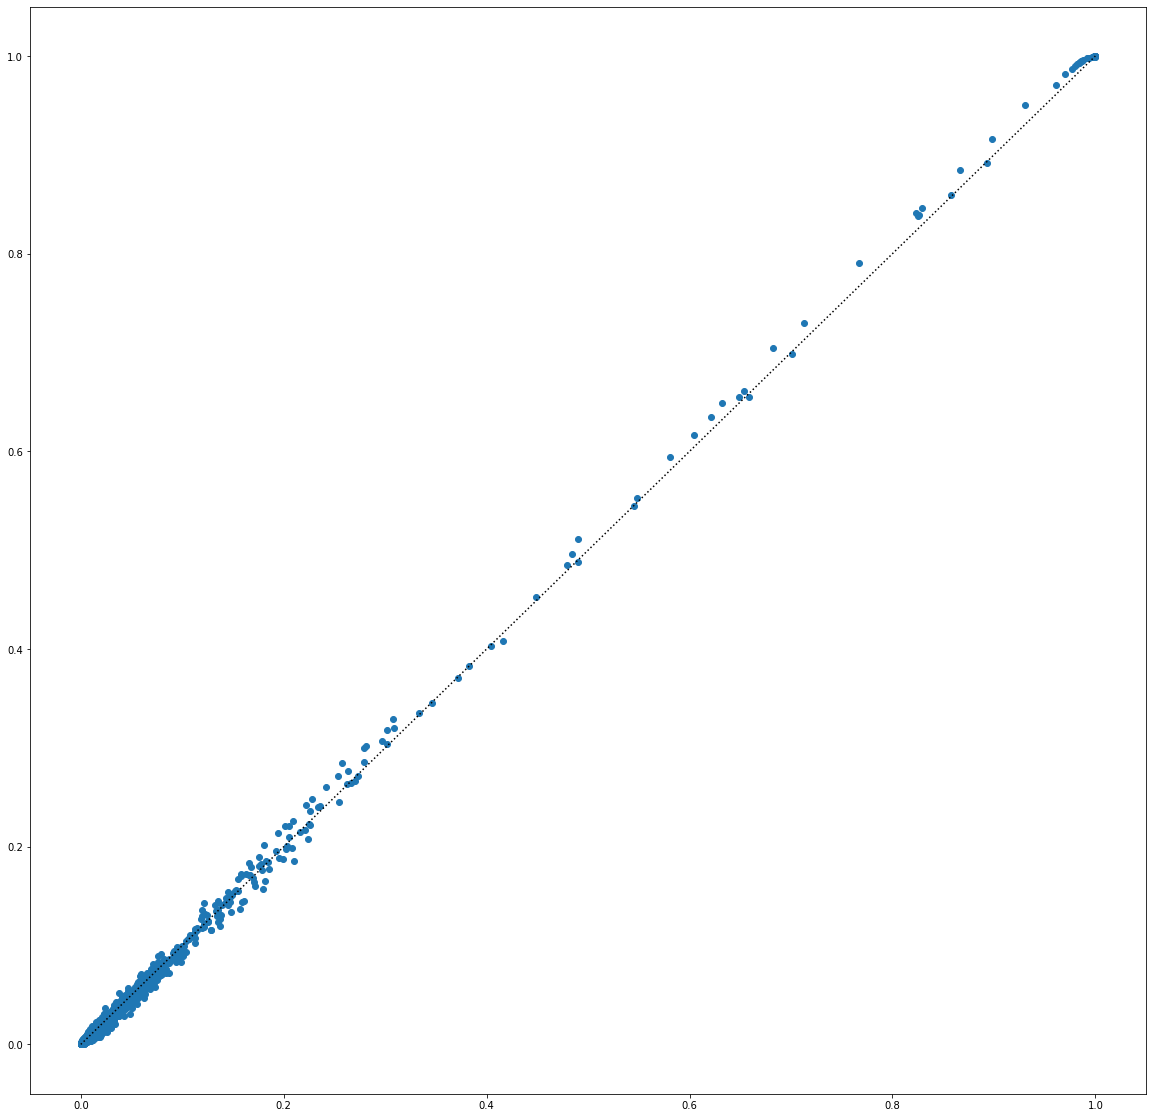

In [15]:
px=x.mean(axis=0)
pg=s.mean(axis=0)
plt.scatter(px,pg)
plt.plot([np.min(px),np.max(px)],[np.min(px),np.max(px)],c='black',linestyle=':')

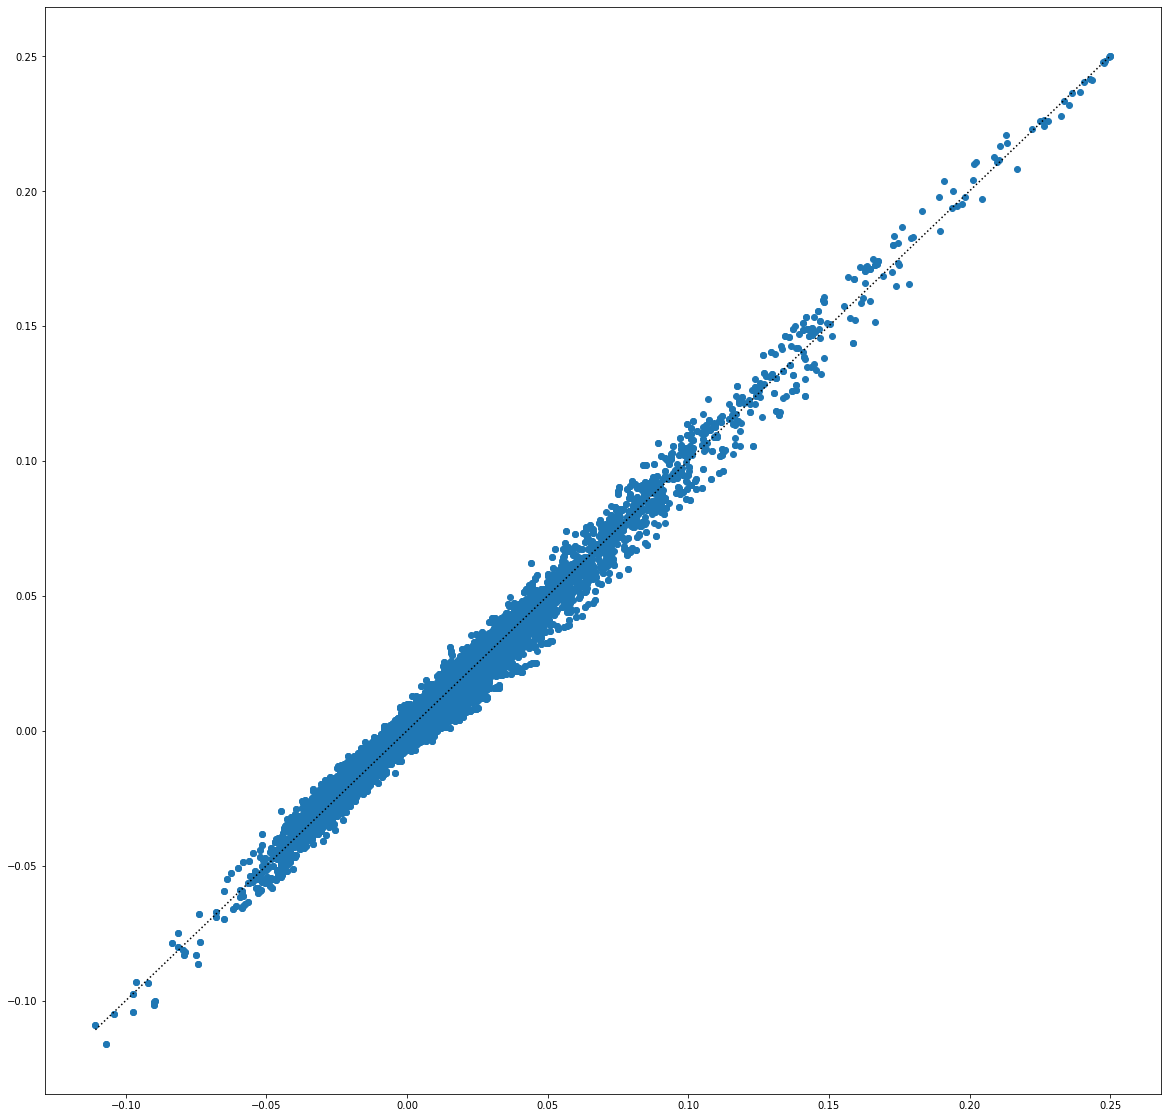

In [16]:
ppx=(np.matmul(x.T,x)/x.shape[0]-np.multiply(px[np.newaxis,:],px[:,np.newaxis])).flatten()
ppg=(np.matmul(s.T,s)/s.shape[0]-np.multiply(pg[np.newaxis,:],pg[:,np.newaxis])).flatten()
plt.scatter(ppx,ppg)
plt.plot([np.min(ppx),np.max(ppx)],[np.min(ppx),np.max(ppx)],c='black',linestyle=':')

## Performance: PCA

In [17]:
pca = PCA(n_components=2)
pca.fit(x)

PCA(n_components=2)

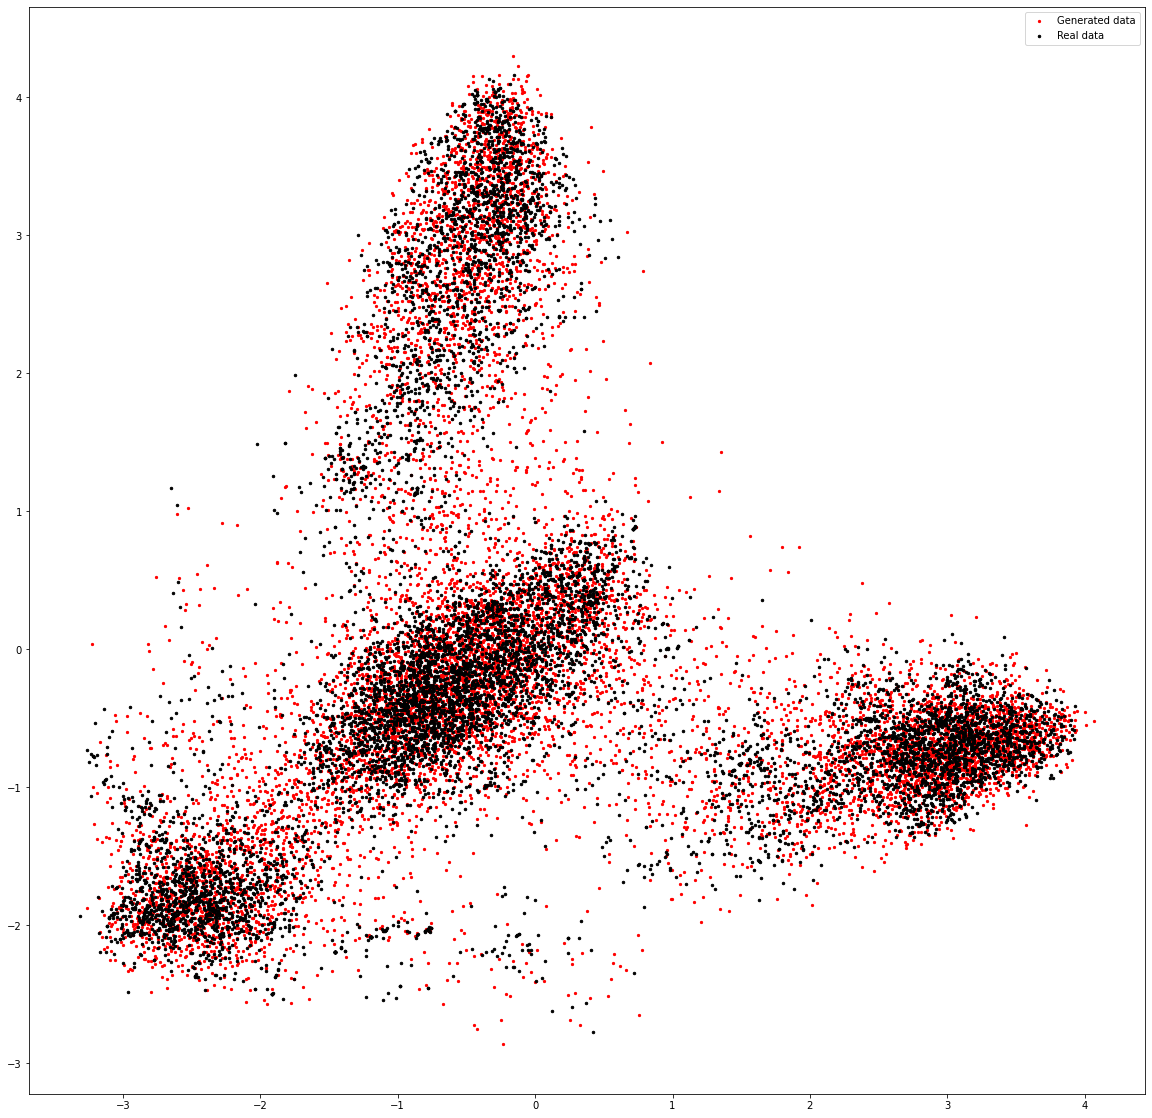

In [18]:
xpca=pca.transform(x)
gpca=pca.transform(s)
if comparetodata is not None:
    xcpca=pca.transform(xc)

plt.scatter(gpca[:,0],gpca[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcpca[:,0],xcpca[:,1], c='green',label='Other method')
plt.scatter(xpca[:,0],xpca[:,1], s=6, c='black',label='Real data')
plt.legend()

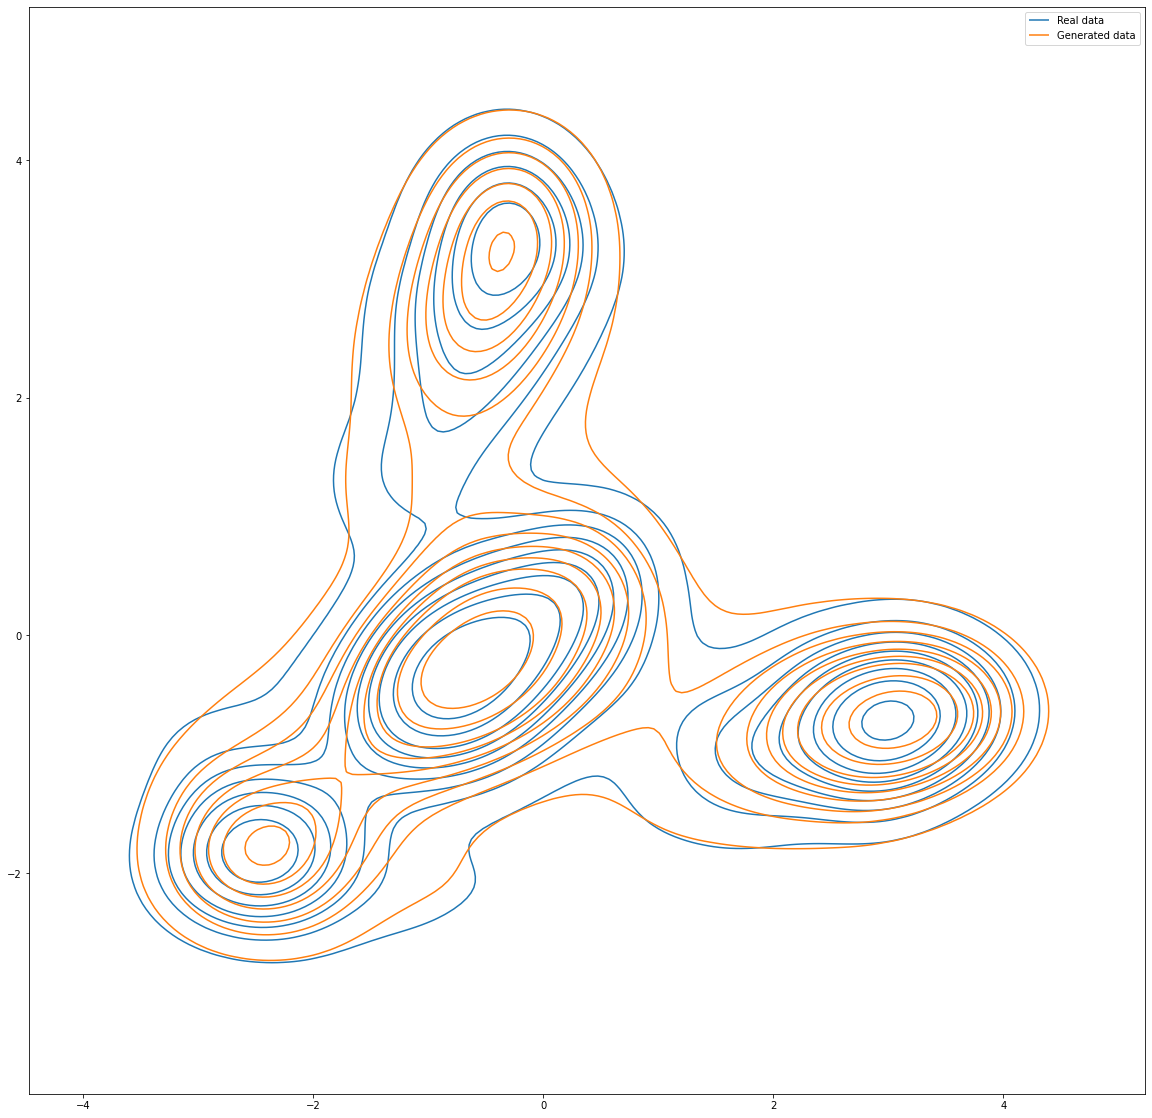

In [19]:
sns.kdeplot(x=xpca[:,0], y=xpca[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gpca[:,0], y=gpca[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()

## Performance: UMAP

In [20]:
proj = UMAP()
proj.fit(np.vstack([x,s]))

UMAP(dens_frac=0.0, dens_lambda=0.0)

/home/szamuner/.local/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


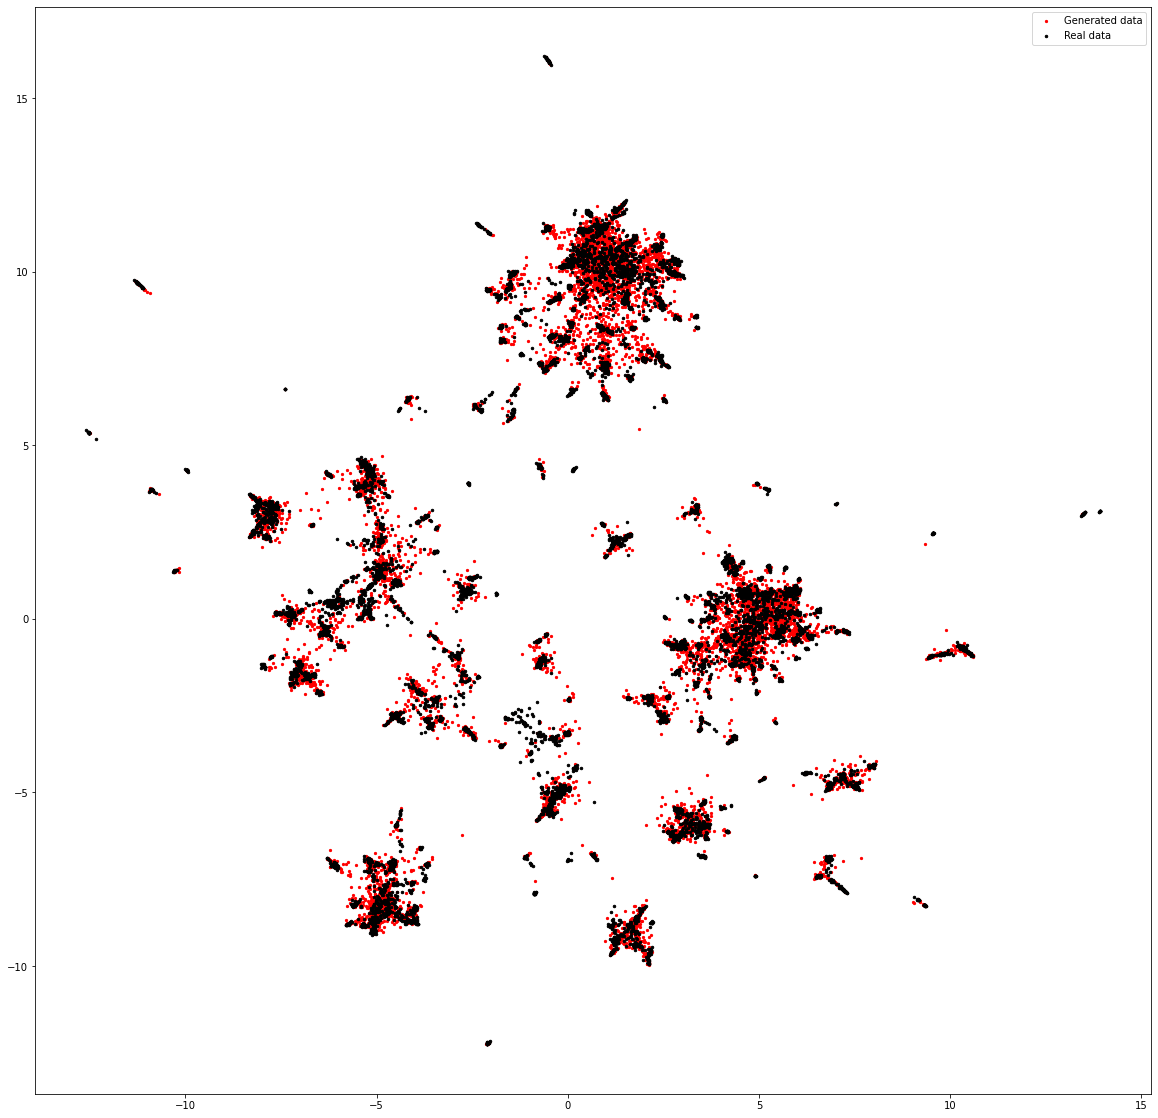

In [21]:
xumap=proj.transform(x)
gumap=proj.transform(s)
if comparetodata is not None:
    xcumap=proj.transform(xc)

plt.scatter(gumap[:,0],gumap[:,1], s=5, c='red', label='Generated data')
if comparetodata is not None:
    plt.scatter(xcumap[:,0],xcumap[:,1], c='green',label='Other method')
plt.scatter(xumap[:,0],xumap[:,1], s=6, c='black',label='Real data')
plt.legend()

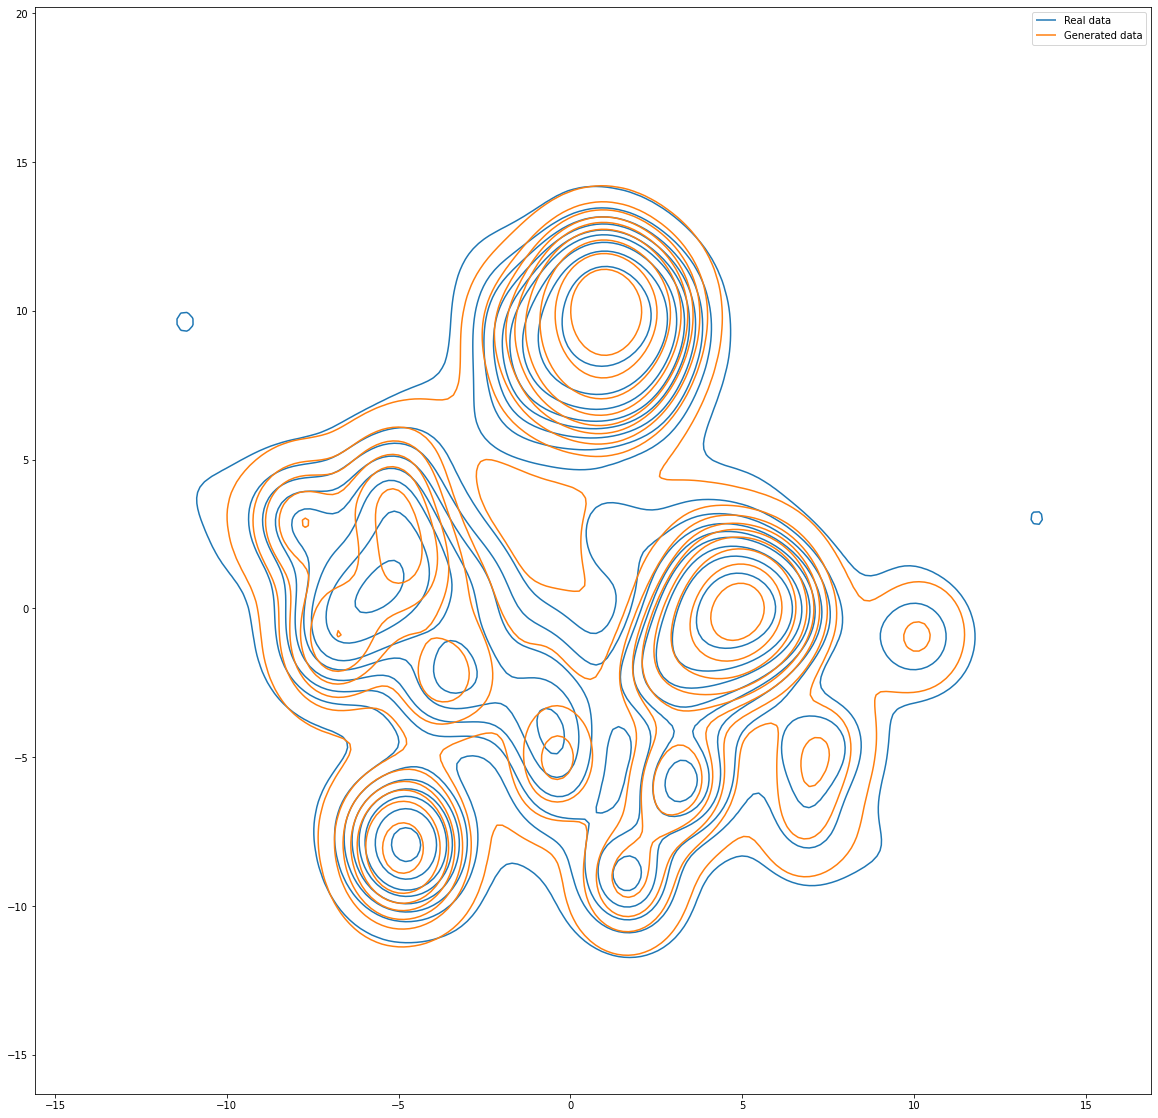

In [22]:
sns.kdeplot(x=xumap[:,0], y=xumap[:,1], levels=10, bw_adjust=1, label='Real data')
sns.kdeplot(x=gumap[:,0], y=gumap[:,1], levels=10, bw_adjust=1, label='Generated data')
plt.legend()